<a href="https://colab.research.google.com/github/ccosmin97/prostate_mri_us_biopsy_dcm_conversion/blob/main/main_stl_seg_to_dcm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The pupose of this notebook is to showcase the different steps required for conversion of prostate and lesion surfaces embedded in STL files, to DICOM SEG and DICOM STL objects.

# Imports and tools download

In [ ]:
!pip install pydicom

In [ ]:
import pandas as pd
import os
import glob
import io
import pydicom
import json
import shutil

# Conversion tools download

PixelMed setup

In [ ]:
!git clone https://github.com/maxfscher/DICOMwsiWorkflow.git
!git clone https://github.com/ImagingDataCommons/idc-wsi-conversion.git

In [ ]:
#output verbose is too long -- below command hides it
# %%capture
!mkdir Data
!apt-get update
!apt install -y default-jre
!apt-get install -y unzip
!apt-get install nano
!apt-get install -y python3-pip
!apt-get install -y libtiff-tools
!apt-get install -y bc
!apt-get install -y openjdk-8-jdk
!apt-get install -y openjdk-8-jre
!apt-get install -y dicom3tools
!pip install tifffile
!pip install pydicom
!apt-get -y install git

!apt install wget
!wget http://www.dclunie.com/pixelmed/software/20240108_current/pixelmed.jar
!wget http://www.dclunie.com/pixelmed/software/20240108_current/pixelmedjavadicom_dependencyrelease.20240108.tar.bz2

!wget https://github.com/maxfscher/DICOMwsiWorkflow/raw/main/execute.sh
!wget https://github.com/maxfscher/DICOMwsiWorkflow/raw/main/gdcsvstodcm.sh
!mkdir idc-wsi-conversion/pixelmed
!mkdir idc-wsi-conversion/jai_imageio
!mkdir idc-wsi-conversion/javax.json-1.0.4
!mkdir idc-wsi-conversion/opencsv-2.4
!mkdir Dependencies
!unzip pixelmed.jar -d idc-wsi-conversion/pixelmed/
!unzip idc-wsi-conversion/jai_imageio.jar -d /idc-wsi-conversion/jai_imageio
!unzip idc-wsi-conversion/javax.json-1.0.4.jar -d /idc-wsi-conversion/javax.json-1.0.4
!unzip idc-wsi-conversion/opencsv-2.4.jar -d /idc-wsi-conversion/opencsv-2.4/
!tar -xvjf pixelmedjavadicom_dependencyrelease.20240108.tar.bz2 -C Dependencies/
!mv Dependencies/lib/ idc-wsi-conversion
!rm -r Dependencies
!rm -r idc-wsi-conversion/gdcsvstodcm.sh
!mkdir idc-wsi-conversion/Data
!mv gdcsvstodcm.sh idc-wsi-conversion
!mv pixelmed.jar idc-wsi-conversion
!chmod +x idc-wsi-conversion/gdcsvstodcm.sh

In [ ]:
!sudo apt-get install dcmtk

In [ ]:
!pip install dcm2niix

In [ ]:
PIXELMEDDIR="/content/idc-wsi-conversion/pixelmed"
PATHTOADDITIONAL="/content/idc-wsi-conversion/lib/additional"

Dcmqi - conversion from NIFTI to DICOM SEG

In [ ]:
!wget https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz
!tar zxvf dcmqi-1.2.5-linux.tar.gz
!cp dcmqi-1.2.5-linux/bin/* /usr/local/bin/

dicom3tools - Conversion from labelmap (.nii) to DICOM SEG objects

In [ ]:
!sudo apt-get install xutils-dev

In [ ]:
!wget https://dclunie.com/dicom3tools/workinprogress/dicom3tools_1.00.snapshot.20220618093127.tar.bz2
!bunzip2 dicom3tools_1.00.snapshot.20220618093127.tar.bz2
!tar xf dicom3tools_1.00.snapshot.20220618093127.tar
!mv dicom3tools_1.00.snapshot.20220618093127 dicom3tools

In [ ]:
!cd dicom3tools && ./Configure && imake -I./config -DInstallInTopDir -DUseXXXXID && make World && make install

dicomsort - Sort DICOM objects by PatientID/StudyUID/SerieUID/SOPUID.dcm

In [ ]:
# dicomsort is the pythong package that can sort DICOM files into
# folder organization based on user-specified DICOM attributes
!git clone https://github.com/pieper/dicomsort.git

# Github demo repository download

This repository contains all of our samples, which we are going to use in this demo notebook.

In [ ]:
!git clone https://github.com/ImagingDataCommons/prostate_mri_us_biopsy_dcm_conversion

# STL to Labelmap

Conversion from STL to labelmap (nii/nrrd) is done through Slicer, using method mentioned [here](https://slicer.readthedocs.io/en/latest/developer_guide/script_repository.html#rasterize-a-model-and-save-it-to-a-series-of-image-files). Since Slicer does not run natively in Google Colab, we included the snipped code for this conversion step with brief explanations.

The conversion Slicer script is also available in our demo github repository, [here](https://github.com/ImagingDataCommons/prostate_mri_us_biopsy_dcm_conversion/blob/main/utils/convert_STL_labelmap_slicer_script.py).

The terminal command run over the Slicer-based python script is provided below as an example:

`<path to Slicer executable> --no-splash --no-main-window --python-script "<root-folder-path-to-script>/convert_STL_labelmap_slicer_script.py.py"`

The script has pre-defined paths for the location of the STL files and the output labelmaps files, so please change these paths inside the script itself.

Mentioned scripts iterates over the STL files and finds the reference T2W image **.nrrd** file, used as a reference node for the output labelmap segmentations. Resulting labelmaps have the same geometry and orientation as the segmented MRI T2W image.

For demo purposes, we have the processed labelmaps in our repository, in the data_samples folder.

Below is a snippet code of the slicer script

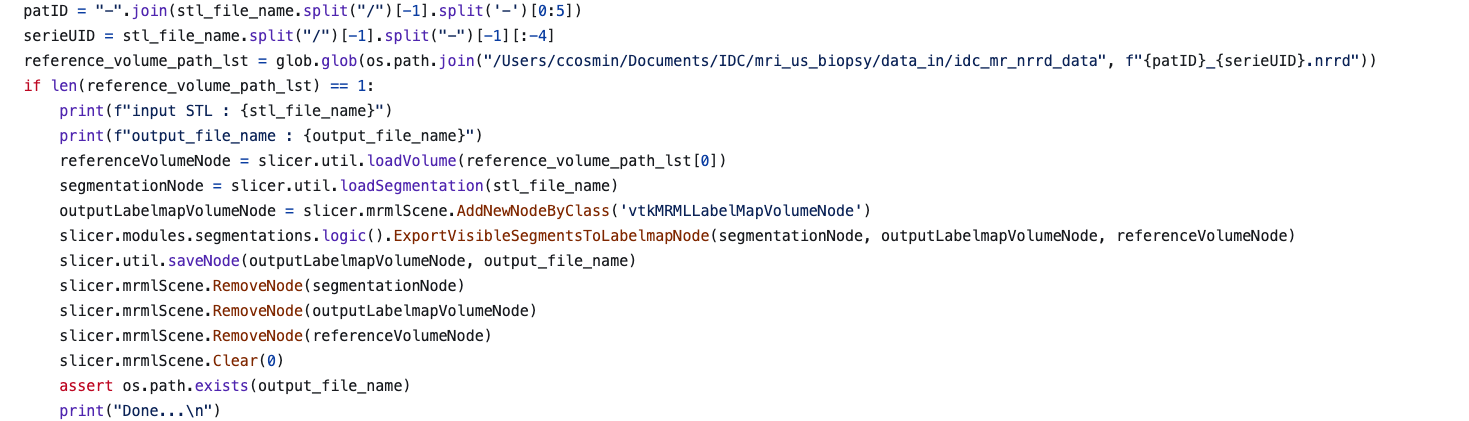

# Download MRI T2W data from Imaging Data Commons

Retrieve image SeriesUIDs from STL surfaces file names

In [ ]:
STL_filenames = glob.glob("prostate_mri_us_biopsy_dcm_conversion/data_samples/prostate_STL/*.STL") + \
glob.glob("prostate_mri_us_biopsy_dcm_conversion/data_samples/lesion_STL/*.STL")
image_SeriesUIDs = [x.split("/")[-1].split("-")[-1][:-4] for x in STL_filenames]

Download collection MRI T2W imaging data, in Imaging Data Commons, using BigQuery tool

Users need a GCP account and a GCP project to use BigQuery.

To simplify reproduciblity, we directly download here the IDC manifest containing the results of the bigquery command.

In [ ]:
selection_manifest  = "/content/prostate_mri_us_biopsy_dcm_conversion/data_samples/idc_manifest.txt"

In [ ]:
# from google.cloud import bigquery
# bq_client = bigquery.Client("idc-sandbox-003")
# selection_query = f"""
#   SELECT
#     *
#   FROM
#     `bigquery-public-data.idc_current.dicom_all`
#   WHERE
#     collection_id = 'prostate_mri_us_biopsy'
#     AND Modality IN ('MR')
#     AND SeriesInstanceUID IN UNNEST({image_SeriesUIDs})"""
# selection_result = bq_client.query(selection_query)
# selection_df = selection_result.result().to_dataframe()

Define IDC images paths

In [ ]:
idc_downloads_path = "IDC_DATA"
if not os.path.exists(idc_downloads_path):
  !mkdir -p $idc_downloads_path
idc_downloads_sorted_path = "IDC_DICOM_IMAGES_SORTED"
if not os.path.exists(idc_downloads_sorted_path):
  !mkdir -p $idc_downloads_sorted_path

Download data locally from gcs_urls and sort by PatientID/StudyUID/SerieUID

In [ ]:
# # save the list of GCS URLs into a file
# selection_manifest = os.path.join(idc_downloads_path, "idc_manifest.txt")
# selection_df["gcs_url"].to_csv(selection_manifest, header=False, index=False)
!cat {selection_manifest} | gsutil -m cp -Ir $idc_downloads_path #download gcs_urls into output_folder
#sort dicom donwload data per PatID/studyUID/serieUID
!python dicomsort/dicomsort.py -k -u $idc_downloads_path {idc_downloads_sorted_path}/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm

# Convert to DICOM SEG

### Prostate conversion to SEG DICOM

In [ ]:
json_path = "prostate_mri_us_biopsy_dcm_conversion/metadata/metadata_mri_us_biopsy_prostate.json"

manually define output path

In [ ]:
if not os.path.exists("output_dicom_seg_prostate"):
  !mkdir -p output_dicom_seg_prostate

Here we iterate over the labelmaps, find the reference IMAGE DICOM objects, define the dicom segmentaion metadata (.json file) and pass it all to dcmqi - itkimage2segimage tool to convert to SEG DICOM.

In [ ]:
for labelmap_prostate_lesion in glob.glob("prostate_mri_us_biopsy_dcm_conversion/data_samples/prostate_labelmaps/*.nii.gz"):
  patientID = "-".join(labelmap_prostate_lesion.split("/")[-1].split('-')[0:5])
  refSerieUID = labelmap_prostate_lesion.split("/")[-1].split("-")[-1][:-7]
  t2_dcm_folder = glob.glob(os.path.join(idc_downloads_sorted_path, f"{patientID}/**/{refSerieUID}/"))[0]
  assert os.path.exists(t2_dcm_folder)
  output_path = os.path.join("/content/output_dicom_seg_prostate", labelmap_prostate_lesion.split('/')[-1][:-7]+'.dcm')
  print(f'labelmap seg nii processed path : {os.path.abspath(labelmap_prostate_lesion)}')
  print(f't2_dcm_folder path : {os.path.abspath(t2_dcm_folder)}')
  print(f'metadata_path : {os.path.abspath(json_path)}')
  print(f'output_path : {os.path.abspath(output_path)}')
  assert os.path.exists
  !/content/dcmqi-1.2.5-linux/bin/itkimage2segimage --inputImageList $labelmap_prostate_lesion --inputDICOMDirectory $t2_dcm_folder --inputMetadata $json_path --outputDICOM $output_path
  print()

### Lesion labelmaps conversion to DICOM SEG

Modifies lesion metatada.json to propagate lesion number into dicom attributes

In [ ]:
def modify_dcmqi_json(json_input, value_target, output_path="", key="SegmentDescription"):
    if output_path=="":
        output_path=json_input
    f = open(json_input)
    json_dic = json.load(f)
    if key != "SeriesDescription":
        json_dic["segmentAttributes"][0][0][key] = value_target
    else:
        json_dic[key] = value_target
    f.close()
    with open(output_path, "w") as outfile:
        json.dump(json_dic, outfile, indent=4)

In [ ]:
json_path = "prostate_mri_us_biopsy_dcm_conversion/metadata/metadata_mri_us_biopsy_target.json"

In [ ]:
if not os.path.exists("out_dicom_seg_lesion"):
  !mkdir -p out_dicom_seg_lesion

In [ ]:
for labelmap_prostate_lesion in glob.glob("prostate_mri_us_biopsy_dcm_conversion/data_samples/lesion_labelmaps/*.nii.gz"):
  patientID = "-".join(labelmap_prostate_lesion.split("/")[-1].split('-')[0:5])
  refSerieUID = labelmap_prostate_lesion.split("/")[-1].split("-")[-1][:-7]
  target_ID = labelmap_prostate_lesion.split("/")[-1].split('-')[5][-1]
  modify_dcmqi_json(json_path, f"Prostate lesion {target_ID} converted from STL", "./temp.json", key="SegmentDescription")
  modify_dcmqi_json("./temp.json", f"Lesion {target_ID}", "./temp.json", key="SegmentLabel")
  modify_dcmqi_json("./temp.json", f"Segmentation of prostate lesion {target_ID}", "./temp.json", key="SeriesDescription")
  print(f'labelmap seg nii processed : {labelmap_prostate_lesion}')
  print(patientID)
  print(refSerieUID)
  t2_dcm_folder = glob.glob(os.path.join(idc_downloads_sorted_path, f"{patientID}/**/{refSerieUID}/"))[0]
  print(f't2_dcm_folder : {t2_dcm_folder}')
  assert os.path.exists(t2_dcm_folder)
  #define output_path
  output_path = os.path.join("/content/out_dicom_seg_lesion", labelmap_prostate_lesion.split('/')[-1][:-7]+'.dcm')
  !/content/dcmqi-1.2.5-linux/bin/itkimage2segimage  --inputImageList $labelmap_prostate_lesion --inputDICOMDirectory $t2_dcm_folder --inputMetadata {"./temp.json"}  --outputDICOM $output_path
  print()

# Conversion to DICOM STL

### Prostate STL Conversion

In [ ]:
output_path_stl_dicom_pixelmed = "output_path_prostate_stl_dicom_pixelmed"
if not os.path.exists(output_path_stl_dicom_pixelmed):
  !mkdir -p $output_path_stl_dicom_pixelmed
else:
  !rm -rf $output_path_stl_dicom_pixelmed

Iterate over STL prostate surface files, get corresponding DICOM MR imaging data and run pixelmed/EncapsulateData converter to STL DICOM.

In [ ]:
for stl_current in glob.glob("prostate_mri_us_biopsy_dcm_conversion/data_samples/prostate_STL/*.STL"):
  patID = '-'.join(stl_current.split('/')[-1].split('-')[0:5])
  refSerieUID = stl_current.split('/')[-1].split('-')[-1].replace(".STL", "")
  label = stl_current.split('/')[-1].split('-')[-3]
  print("Current STL processed : ")
  print(f"PatID : {patID}")
  print(f"SerieUID : {refSerieUID}")
  print(f"label : {label}")
  in_dcm_mr_sop_file = glob.glob(os.path.join(idc_downloads_sorted_path, f"{patID}/**/{refSerieUID}/*.dcm"))[0]
  print(f"REF image modality : {pydicom.dcmread(in_dcm_mr_sop_file).Modality}")
  assert os.path.exists(in_dcm_mr_sop_file)
  print(in_dcm_mr_sop_file)
  out_pixelmed_stl_dcm = f"output_path_prostate_stl_dicom_pixelmed/{stl_current.split('/')[-1].replace('.STL', '')}.dcm"
  #encapsulate using stl dicom\
  !java -cp /content/idc-wsi-conversion/pixelmed.jar:${PATHTOADDITIONAL}/javax.json-1.0.4.jar:${PATHTOADDITIONAL}/opencsv-2.4.jar:${PATHTOADDITIONAL}/jai_imageio.jar \
  -Djava.awt.headless=true \
  -XX:-UseGCOverheadLimit \
  -Xmx8g \
  com.pixelmed.convert.EncapsulateData $stl_current \
  "" \
  $in_dcm_mr_sop_file \
  $out_pixelmed_stl_dcm

### Lesion STL conversion

In [ ]:
output_path_stl_dicom_pixelmed = "output_path_lesion_stl_dicom_pixelmed"
if not os.path.exists(output_path_stl_dicom_pixelmed):
  !mkdir -p $output_path_stl_dicom_pixelmed
else:
  !rm -rf $output_path_stl_dicom_pixelmed

In [ ]:
for stl_current in glob.glob("prostate_mri_us_biopsy_dcm_conversion/data_samples/lesion_STL/*.STL"):
  patID = '-'.join(stl_current.split('/')[-1].split('-')[0:5])
  refSerieUID = stl_current.split('/')[-1].split('-')[-1].replace(".STL", "")
  label = stl_current.split('/')[-1].split('-')[-3]
  print("Current STL processed : ")
  print(f"PatID : {patID}")
  print(f"SerieUID : {refSerieUID}")
  print(f"label : {label}")
  in_dcm_mr_sop_file = glob.glob(os.path.join(idc_downloads_sorted_path, f"{patID}/**/{refSerieUID}/*.dcm"))[0] #glob.glob(f"mr_dcm_data/{patID}/**/{serieUID}/*.dcm")[0]
  print(f"REF image modality : {pydicom.dcmread(in_dcm_mr_sop_file).Modality}")
  assert os.path.exists(in_dcm_mr_sop_file)
  out_pixelmed_stl_dcm = f"output_path_lesion_stl_dicom_pixelmed/{stl_current.split('/')[-1].replace('.STL', '')}.dcm"
  #encapsulate using stl dicom
  !java -cp /content/idc-wsi-conversion/pixelmed.jar:${PATHTOADDITIONAL}/javax.json-1.0.4.jar:${PATHTOADDITIONAL}/opencsv-2.4.jar:${PATHTOADDITIONAL}/jai_imageio.jar \
  -Djava.awt.headless=true \
  -XX:-UseGCOverheadLimit \
  -Xmx8g \
  com.pixelmed.convert.EncapsulateData $stl_current \
  "" \
  $in_dcm_mr_sop_file \
  $out_pixelmed_stl_dcm

# Verification DICOM tool -- dicom3tools

## DICOM SEG

In [ ]:
for prostate_seg_dicom in glob.glob(f"output_dicom_seg_prostate/*.dcm"):
  !/content/dicom3tools/bin/1.6.1.58.x8664/dciodvfy $prostate_seg_dicom

In [ ]:
for prostate_seg_dicom in glob.glob(f"out_dicom_seg_lesion/*.dcm"):
  !/content/dicom3tools/bin/1.6.1.58.x8664/dciodvfy $prostate_seg_dicom

## DICOM STL

In [ ]:
for prostate_seg_dicom in glob.glob(f"output_path_prostate_stl_dicom_pixelmed/*.dcm"):
  !/content/dicom3tools/bin/1.6.1.58.x8664/dciodvfy $prostate_seg_dicom

In [ ]:
for prostate_seg_dicom in glob.glob(f"output_path_lesion_stl_dicom_pixelmed/*.dcm"):
  !/content/dicom3tools/bin/1.6.1.58.x8664/dciodvfy $prostate_seg_dicom

# Verification of DICOM STL obects

## Prostate

In [ ]:
!mkdir -p unencapsulated_stl_prostate

In [ ]:
for stl_dcm_file in glob.glob("output_path_prostate_stl_dicom_pixelmed/*.dcm"):
    pydicom_dataset = pydicom.dcmread(stl_dcm_file)
    encapsulatedDocument = pydicom_dataset.EncapsulatedDocument
    encapsulatedDocumentLength = pydicom_dataset.EncapsulatedDocumentLength
    read_buffer = io.BytesIO(encapsulatedDocument)
    patID = '-'.join(stl_dcm_file.split('/')[-1].split('-')[0:5])
    refSerieUID = stl_dcm_file.split('/')[-1].split('-')[-1].replace(".dcm", "")
    in_dcm_mr_sop_file = glob.glob(os.path.join(idc_downloads_sorted_path, f"{patID}/**/{refSerieUID}/*.dcm"))[0]
    uncencapsulated_path_stl_dicom = f"unencapsulated_stl_prostate/{stl_dcm_file.split('/')[-1][:-4]}.STL"
    with open(uncencapsulated_path_stl_dicom, 'wb') as file:
        shutil.copyfileobj(read_buffer, file)
    try :
      assert pydicom_dataset.StudyInstanceUID == pydicom.dcmread(in_dcm_mr_sop_file).StudyInstanceUID, f"StudyInstanceUID check failed"#StudyInstanceUID check
    except AssertionError as e:
      print(e)
    try:
      assert pydicom_dataset.PatientID == pydicom.dcmread(in_dcm_mr_sop_file).PatientID, f"PatientID check failed"
    except AssertionError as e:
      print(e)
    try:
      assert pydicom_dataset.StudyDate == pydicom.dcmread(in_dcm_mr_sop_file).StudyDate, "StudyDate check failed"
    except AssertionError as e:
      print(e)
    try:
      assert pydicom_dataset.StudyDescription == pydicom.dcmread(in_dcm_mr_sop_file).StudyDescription, "StudyDescription check failed"
    except AssertionError as e:
      print(e)
    try:
      assert pydicom_dataset.StudyTime == pydicom.dcmread(in_dcm_mr_sop_file).StudyTime, "StudyTime check failed"
    except AssertionError as e:
      print(e)
    # #make sure uncencapsulated stl files and original stl files are the same size and identical
    stl_in = glob.glob(f"prostate_mri_us_biopsy_dcm_conversion/data_samples/prostate_STL/{stl_dcm_file.split('/')[-1].replace('.dcm', '.STL')}")[0]
    !cmp $stl_in $uncencapsulated_path_stl_dicom
    !/content/dicom3tools/bin/1.6.1.58.x8664/dciodvfy $stl_dcm_file

## Lesion

In [ ]:
!mkdir -p unencapsulated_stl_lesion

In [ ]:
for stl_dcm_file in glob.glob("output_path_lesion_stl_dicom_pixelmed/*.dcm"):
    pydicom_dataset = pydicom.dcmread(stl_dcm_file)
    encapsulatedDocument = pydicom_dataset.EncapsulatedDocument
    encapsulatedDocumentLength = pydicom_dataset.EncapsulatedDocumentLength
    read_buffer = io.BytesIO(encapsulatedDocument)
    patID = '-'.join(stl_dcm_file.split('/')[-1].split('-')[0:5])
    refSerieUID = stl_dcm_file.split('/')[-1].split('-')[-1].replace(".dcm", "")
    in_dcm_mr_sop_file = glob.glob(os.path.join(idc_downloads_sorted_path, f"{patID}/**/{refSerieUID}/*.dcm"))[0]
    uncencapsulated_path_stl_dicom = f"unencapsulated_stl_lesion/{stl_dcm_file.split('/')[-1][:-4]}.STL"
    with open(uncencapsulated_path_stl_dicom, 'wb') as file:
        shutil.copyfileobj(read_buffer, file)
    try :
      assert pydicom_dataset.StudyInstanceUID == pydicom.dcmread(in_dcm_mr_sop_file).StudyInstanceUID, f"StudyInstanceUID check failed"#StudyInstanceUID check
    except AssertionError as e:
      print(e)
    try:
      assert pydicom_dataset.PatientID == pydicom.dcmread(in_dcm_mr_sop_file).PatientID, f"PatientID check failed"
    except AssertionError as e:
      print(e)
    try:
      assert pydicom_dataset.StudyDate == pydicom.dcmread(in_dcm_mr_sop_file).StudyDate, "StudyDate check failed"
    except AssertionError as e:
      print(e)
    try:
      assert pydicom_dataset.StudyDescription == pydicom.dcmread(in_dcm_mr_sop_file).StudyDescription, "StudyDescription check failed"
    except AssertionError as e:
      print(e)
    try:
      assert pydicom_dataset.StudyTime == pydicom.dcmread(in_dcm_mr_sop_file).StudyTime, "StudyTime check failed"
    except AssertionError as e:
      print(e)
    # #make sure uncencapsulated stl files and original stl files are the same size and identical
    stl_in = glob.glob(f"prostate_mri_us_biopsy_dcm_conversion/data_samples/lesion_STL/{stl_dcm_file.split('/')[-1].replace('.dcm', '.STL')}")[0]
    !cmp $stl_in $uncencapsulated_path_stl_dicom
    !/content/dicom3tools/bin/1.6.1.58.x8664/dciodvfy $stl_dcm_file

# MISC

## Unencapsulate DICOM STL data into STL

In [ ]:
example_stl_dicom = glob.glob("output_path_lesion_stl_dicom_pixelmed/*.dcm")[0]
pydicom_dataset = pydicom.dcmread(example_stl_dicom)
encapsulatedDocument = pydicom_dataset.EncapsulatedDocument
encapsulatedDocumentLength = pydicom_dataset.EncapsulatedDocumentLength
read_buffer = io.BytesIO(encapsulatedDocument)
if read_buffer.getbuffer().nbytes != encapsulatedDocumentLength :
  read_buffer = read_buffer[0:read_buffer.getbuffer() - (read_buffer.getbuffer().nbytes - encapsulatedDocumentLength)-1]
out_unencapsulated_python_stl = f"./{example_stl_dicom.split('/')[-1].replace('.dcm', '.STL')}"
with open(out_unencapsulated_python_stl, 'wb') as file:
    shutil.copyfileobj(read_buffer, file)